# Short Time Fourier Transform (STFT)

ใน part 2 เราได้เรียนรู้เพิ่มเติมเกี่ยวกับการแปลงข้อมูล $x[n]$ จาก time domain ไปเป็น $X[k]$ ใน frequency domain ผ่านการใช้ discrete Fourier transform (DFT) 

หากเรา plot ดูข้อมูล $X[k]$ จะสามารถบอกได้ว่า signal ที่เรากำลังวิเคราะห์อยู่มีสัญญาณที่ความถี่ใดบ้าง และมีสัดส่วนจากความถี่ไหนมากหรือน้อยกว่ากัน

หลังจากนั้นเราก็ได้ลองกำจัดความถี่บางส่วนออกจาก signal โดยการทำ filtering ด้วยฟังก์ชัน window

---

ใน part นี้เราจะมาลองดู signal ที่มีหน้าตาซับซ้อนมากยิ่งขึ้น เช่น chirp signal ซึ่งเป็น signal ที่มีความถี่ในช่วงเวลาใดๆ เพียงค่าเดียว แต่เมื่อเวลาเปลี่ยนไป ค่าความถี่นั้นจะเปลี่ยนไป และมีค่าสูงขึ้นเรื่อยๆ ตามแกนเวลา

In [1]:
import numpy as np
from scipy.signal import chirp, stft, spectrogram
from scipy.fft import fft, fftfreq, ifft
import matplotlib.pyplot as plt
import math

ฟังก์ชันจาก part ก่อนหน้า

In [2]:
def compute_DFT(x_sampled, t_sampled, f_s, duration):

  # คำนวณจำนวนจุดที่มีใน signal
  num_points = x_sampled.shape[0]

  # ใช้ DFT ในการแปลง
  X_fft = fft(x_sampled)
  freq = np.fft.fftfreq(num_points, d=1/f_s)

  return X_fft, freq


def plot_discrete_time_freq_signal(x_sampled, X_fft, freq):

  fig, ax = plt.subplots(2,1, figsize=(15, 8))
  fig.tight_layout(pad=5.0)
  
  # โดยปกติแล้วเวลาเรากราฟ discrete time signal เราจะใช้ n เป็นแกน x แทนที่จะใช้เวลาจริงในแกน x
  ax[0].scatter(range(x_sampled.shape[0]), x_sampled, c='r')
  ax[0].set(xlabel='n',ylabel='x[n]')
  ax[0].set_title(f"Discrete time signal x[n] sampled from x(t)")
  ax[0].grid(True)
  
  ax[1].plot(freq,np.abs(X_fft))
  ax[1].set(xlabel='Frequency (Hz)',ylabel='|X[k]|')
  ax[1].set_title(f"X[k], DFT of x[n]")
  ax[1].set_xticks(np.arange(np.min(freq),np.max(freq),10))
  ax[1].grid(True)

  plt.show()

ทดลองสร้าง Chirp signal

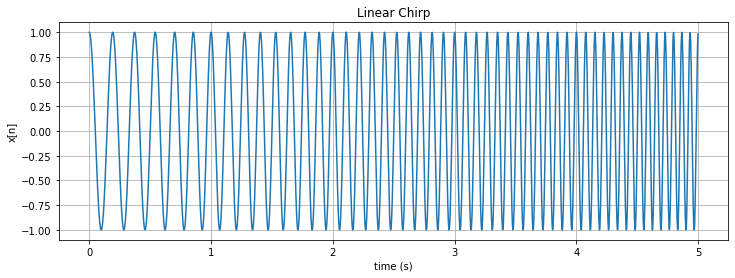

In [3]:
f_s = 500 # อัตราการเก็บข้อมูล หรือ sampling rate (samples/sj หรือ Hz)
duration = 5 # ระยะเวลาของ signal (s)

# คำนวณค่า sampling period (ระยะห่างระหว่างจุดที่เก็บมาสองจุดในแกนเวลา)
T = 1/f_s 

# คำนวณจำนวนจุดที่มีใน signal
num_points = math.floor(f_s*duration)

# สร้างแกนเวลา
t_sampled = np.linspace(0.0, num_points*T, num_points, endpoint=False)

# สร้าง chirp signal ที่มีค่าความถี่เริ่มต้นที่ 5 Hz และมีค่าความถี่สูงขึ้นเรื่อยๆ จนไปถึงค่า 15 Hz ในระยะเวลา 5 วินาที
x_chirp = chirp(t_sampled, f0=5, f1=15, t1=duration, method='linear')

fig, ax = plt.subplots(figsize=(12,4))

# ถึงแม้ว่าข้อมูลเราจะเป็น discrete time signal แต่สำหรับตัวอย่างนี้เราจะใช้ plot 
# แทน scatter ที่เราใช้กันมาใน part แรกๆ เพื่อให้สามารถดูหน้าตาของ signal ได้ง่ายขึ้น 
# รวมถึงใส่ xlabel เป็นเวลา แทนที่จะเป็น n
ax.plot(t_sampled, x_chirp)
ax.set_title(f"Linear Chirp")
ax.set(xlabel='time (s)', ylabel='x[n]')
ax.grid(True)
plt.show()

ลองใช้ `fft` แปลง $x_{chirp}$ จาก time domain ไปเป้น frequency domain ดู

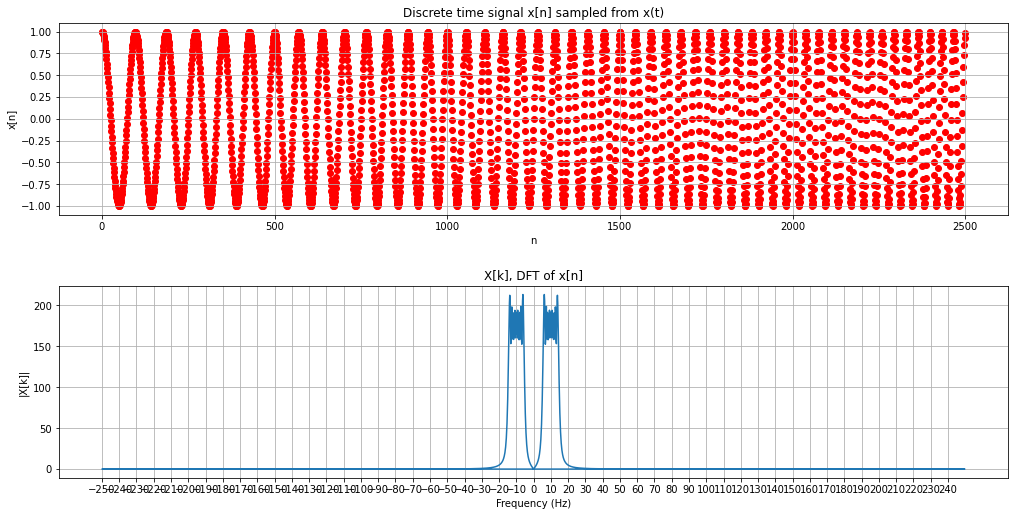

In [4]:
# คำนวณ DFT ของ x[n] และ แกน freq สำหรับใช้ plot
X_fft, freq = compute_DFT(x_chirp, t_sampled, f_s, duration)

# Plot ผลที่ได้
plot_discrete_time_freq_signal(x_chirp, X_fft, freq)

จากการดู chirp signal ใน frequency domain เราพบว่า ข้อมูลของเรามีค่าสูงในบริเวณ ค่าความถี่ประมาณ 5 Hz ถึง 15 Hz ซึ่งสอดคล้องกับค่าความถี่ที่เราใช้ในการสร้าง chirp signal อันนี้

แต่มีสิ่งหนึ่งที่เราไม่สามารถบอกได้จากข้อมูลใน frequency domain เลย ก็คือ เราไม่สามารถรู้ว่าค่าความถี่เหล่านั้นเกิดขึ้นที่เวลาเท่าไหร่ของ time signal บ้าง

ตัวอย่าง เช่น 
 
1.   chirp signal ที่มีความถี่เริ่มต้น 5 Hz แล้วมีค่าความถี่เพิ่มขึ้นเรื่อยๆไปเป็น 15 Hz
2.   chirp signal ที่มีความถี่เริ่มต้น 15 Hz แล้วมีค่าความถี่ลดลงเรื่อยๆไปเป็น 5 Hz

จะมี magnitude ใน frequency domain เหมือนกันดังตัวอย่างด้านล่าง

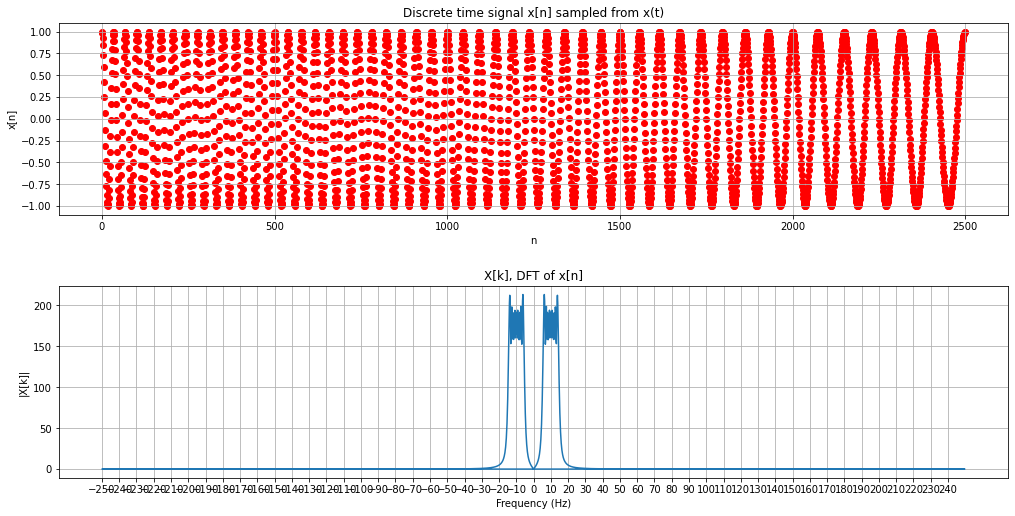

In [5]:
# สร้าง chirp signal ที่มีค่าความถี่เริ่มต้นที่ 15 Hz และมีค่าความถี่ลดลงเรื่อยๆ จนไปถึงค่า 5 Hz ในระยะเวลา 5 วินาที
x_chirp_reverse = chirp(t_sampled, f0=15, f1=5, t1=duration, method='linear')

# คำนวณ DFT ของ x[n] และ แกน freq สำหรับใช้ plot
X_fft_reverse, freq = compute_DFT(x_chirp_reverse, t_sampled, f_s, duration)

# Plot ผลที่ได้
plot_discrete_time_freq_signal(x_chirp_reverse, X_fft_reverse, freq)

หากเราต้องการจะรู้ว่า signal นี้มีค่าความถี่อะไรบ้าง โดยที่อยากจะทราบด้วยว่าค่าความถี่แต่ละอัน มันเกิดขึ้น ณ เวลาที่เท่าไหร่บ้าง เราจะสามารถนำเอา `fft` มาประยุกต์ใช้ได้อย่างไรบ้าง

วิธีที่ตรงไปตรงมา ก็คือเราแบ่ง time signal ของเราเป็นส่วนเล็กๆ (segment) แล้วค่อยใช้ `fft` วิเคราะห์แต่ละ segment แยกกัน

สมมติว่าเราแบ่ง signal ของเราออกเป็นสองส่วนเราก็จะได้ผลดังนี้

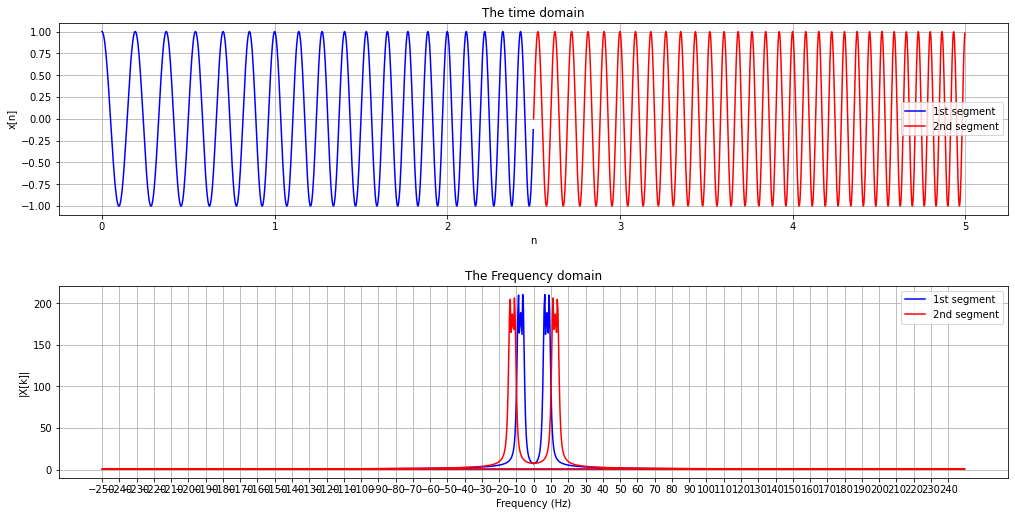

In [6]:
# สร้าง segment แรก โดยการดึงข้อมูลครึ่งแรกของ chirp
x_chirp_first = x_chirp[:int(x_chirp.shape[0]/2)]

# สร้าง segment ที่สอง โดยการดึงข้อมูลครึ่งหลังของ chirp
x_chirp_second = x_chirp[int(x_chirp.shape[0]/2):]

# คำนวณ DFT ของ segment แรก
X_fft_first, freq = compute_DFT(x_chirp_first, t_sampled[:int(x_chirp.shape[0]/2)], f_s, duration/2)

# คำนวณ DFT ของ segment ที่สอง
X_fft_second, freq = compute_DFT(x_chirp_second, t_sampled[int(x_chirp.shape[0]/2):], f_s, duration/2)

# Plot ผลที่ได้
fig, ax = plt.subplots(2,1, figsize=(15, 8))
fig.tight_layout(pad=5.0)

ax[0].plot(t_sampled[:int(x_chirp.shape[0]/2)], x_chirp_first, c='b',label='1st segment')
ax[0].plot(t_sampled[int(x_chirp.shape[0]/2):], x_chirp_second, c='r',label='2nd segment')
ax[0].set(xlabel='n',ylabel='x[n]')
ax[0].set_title(f"The time domain")
ax[0].grid(True)
ax[0].legend()


ax[1].plot(freq,np.abs(X_fft_first),c='b',label='1st segment')
ax[1].plot(freq,np.abs(X_fft_second),c='r',label='2nd segment')
ax[1].set(xlabel='Frequency (Hz)',ylabel='|X[k]|')
ax[1].set_title(f"The Frequency domain")
ax[1].set_xticks(np.arange(np.min(freq),np.max(freq),10))
ax[1].grid(True)
ax[1].legend()

plt.show()

จากผลด้านบน เราสังเกตเห็น


*   ครึ่งแรกของ chirp signal (เวลา t=0s ถึง t=2.5s) มีค่าความถี่ประมาณ 5 Hz ถึง 10 Hz
*   ครึ่งหลังของ chirp signal (เวลา t=2.5s ถึง t=25s) มีค่าความถี่ประมาณ 10 Hz ถึง 15 Hz

จะเห็นได้ว่าเราสามารถบอกข้อมูลเกี่ยวกับค่าความถี่ว่าเกิดขึ้นช่วงประมาณเวลาไหนได้ละเอียดมากยิ่งขึ้น


ถ้าหากเราต้องการให้เราสามารถบอกได้ละเอียดในแกนเวลามากขึ้นอีก เราก็จะทำให้แต่ละ segment เล็กลงได้ การแบ่งให้ time signal มันสั้นลง แล้วคำนวณ DFT แยก ในลักษณะนี้ เป็นที่มาของชื่อเทคนิค Short-Time Fourier Transform (STFT)


---
ในส่วนสุดท้ายของ part นี้ เราจะเรียกใช้ `scipy.signal.spectrogram` ในการคำนวณ STFT ได้อย่างง่ายดาย ซึ่ง spectrogram จะแสดงผลเป็นรูปภาพที่มีแกน x เป็นเวลา มีแกน y เป็นแกนความถี่ และ มีสีที่แสดงถึง magnitude ที่ค่าความถี่และเวลาใดเวลาหนึ่ง



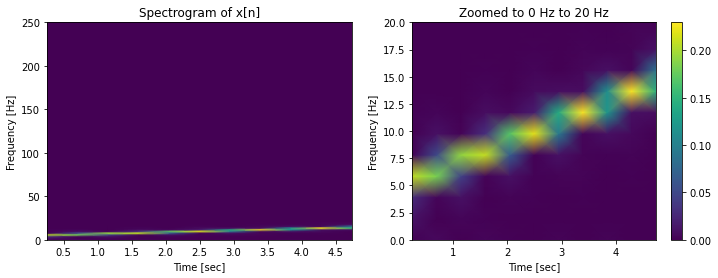

In [7]:
# กำหนดขนาดของแต่ละ time segment
num_pts_per_segment = 256

# คำนวณ spectrogram (อ้างอิงจาก https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.spectrogram.html)
f, t, Sxx = spectrogram(x_chirp, f_s, nperseg=num_pts_per_segment)

# แสดงผล
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Spectrogram of x[n]')

plt.subplot(1,2,2)
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim([0,20])
plt.title('Zoomed to 0 Hz to 20 Hz')
plt.colorbar()
plt.show()

1.   แท่งสีด้านขวาสุดของภาพ (colorbar) เป็นตัวบอกว่าสีอะไรหมายถึงค่าอะไร เช่น สีน้ำเงินเข้มหมายถึงมีค่าเป็น 0 ในขณะที่สีเหลืองหมายถึงมีค่าประมาณ 0.13


2.   หากสังเกต spectrogram จะพบว่า 
 

*   มีสีน้ำเงินเข้ม ที่ความถี่ (แกน y) มีค่ามากกว่า 20 Hz สำหรับทุกค่าเวลา (แกน x) แสดงให้เห็นว่า ใน time signal นี้ไม่มีความถี่ที่สูงกว่า 20 Hz เลย

*   มีสีเหลือง/เขียวบริเวณค่าความถี่ประมาณ 10 Hz ในช่วงเวลา 1 ถึง 2 วินาที แสดงให้เห็นว่า time signal ในช่วงเวลาเริ่มต้นจนถึง 1 วินาที มีค่าความถี่อยู่ที่แถวๆ 6 Hz


*   มีสีเหลือง/เขียวบริเวณค่าความถี่ประมาณ 6 Hz ในช่วงเวลา 0 ถึง 1 วินาที แสดงให้เห็นว่า time signal ในช่วงเวลาดังกล่าว มีค่าความถี่อยู่ที่แถวๆ 10 Hz


*   เมื่อเวลาผ่านไปตามการเวลา signal เรามีค่าความถี่สูงขึ้นเรื่อยๆ สอดคล้องกับ time signal ของเราที่เรากำหนดให้เป็น chirp signal ที่มีค่าความถี่เริ่มต้นที่ 5 Hz และมีค่าความถี่สูงขึ้นเรื่อยๆ จนไปถึงค่า 15 Hz ในระยะเวลา 5 วินาที

จะเห็นได้ว่าการวิเคราะห์ข้อมูลโดยดู spectrogram (time-frequency domain) ช่วยให้เราสามารถทำความเข้าใจ signal เราได้มากขึ้น เมื่อเปรียบเทียบกับการทำ DFT แบบมาตรฐาน โดยเฉพาะในกรณีที่ signal ของเรามีลักษณะที่มีค่าความถี่เปลี่ยนไปขึ้นอยู่กับแกนเวลา (nonstationary signal).

---
เทคนิคนี้สามารถนำเอาไปใช้ในการวิเคราะห์ข้อมูล neuroscience ได้ในหลายประเภท ไม่ว่าจะเป็นไฟล์สัญญาณไฟฟ้าที่เก็บมาจากสมอง ไฟล์เสียงที่เก็บมาจากผู้ป่วย รวมถึงรูปภาพที่เก็บมาจากอุปกรณ์การถ่ายภาพทางการแพทย์ เช่น magnetic resonance image (MRI), computerised tomography (CT) หรือ X-ray


**เกร็ดความรู้**
หากได้ทำการศึกษาเพิ่มเติมเกี่ยวกับ signal processing เราจะทราบว่า ในการใช้ STFT มันมี tradeoff ระหว่าง time resolution และ frequency resolution อยู่ ตัวอย่าง เช่น

1.   ถ้าเราเลือกให้แต่ละ segment มีจำนวนจุดน้อยเราจะสามารถระบุตำแหน่งในแกนเวลาได้ดี แต่เราจะเสีย resolution ในแกน frequency ไป (เราจะไม่สามารถบอกได้ชัดเจนว่าในแต่ละเวลา มีค่าความถี่เป็นเท่าไหร่ได้ด้วยความแม่นยำสูง) - **ภาพเบลอในแกนความถี่**

2.   ถ้าเราเลือกให้แต่ละ segment มีจำนวนจุดมาก เราจะสามารถระบุตำแหน่งในแกน frequency ได้ดี แต่เราจะเสีย resolution ในแกน time ไป (เราจะไม่สามารถบอกได้ชัดเจนว่าความถี่แต่ละอัน มันเกิดขึ้นตรงไหนในแกนเวลาได้ด้วยความแม่นยำสูง) - **ภาพเบลอในแกนเวลา**



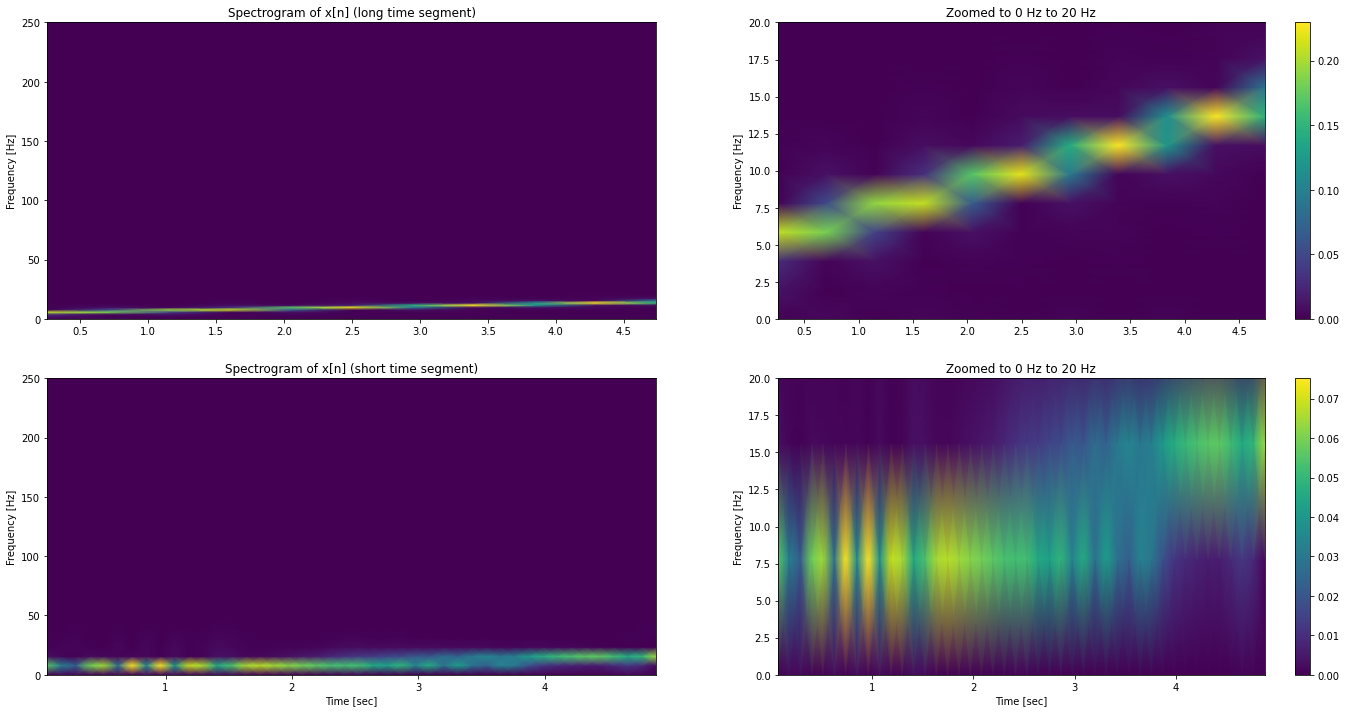

In [8]:
# กำหนดขนาดของแต่ละ time segment
num_pts_per_segment = 256

# คำนวณ spectrogram (อ้างอิงจาก https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.spectrogram.html)
f, t, Sxx = spectrogram(x_chirp, f_s, nperseg=num_pts_per_segment)

# แสดงผล
plt.figure(figsize=(24,12))
plt.subplot(2,2,1)
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.title('Spectrogram of x[n] (long time segment)')

plt.subplot(2,2,2)
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.ylim([0,20])
plt.title('Zoomed to 0 Hz to 20 Hz')
plt.colorbar()

# กำหนดขนาดของ time segment ให้เล็กลง
num_pts_per_segment = 64
# คำนวณ spectrogram (อ้างอิงจาก https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.spectrogram.html)
f, t, Sxx = spectrogram(x_chirp, f_s, nperseg=num_pts_per_segment)

# แสดงผล
plt.subplot(2,2,3)
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Spectrogram of x[n] (short time segment)')

plt.subplot(2,2,4)
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim([0,20])
plt.title('Zoomed to 0 Hz to 20 Hz')
plt.colorbar()
plt.show()